# Correlation Analysis Using a Sparse Linear Predictor
Because linear models are fast to train, we can use them in a brute force search for an optimal sparse feature selection. We can then analyze inter-feature correlations to see that optimal features for a linear model are often minimally correlated. For this experiment, we use a previously implemented Ridge regression model.

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
import seaborn as sns

from scipy.io import loadmat
from modules.ridge import RidgeRegression, rmse

% matplotlib inline

sns.set(context = 'poster', style = 'whitegrid')

We assess the performance of each model with mean squared error.

In [2]:
def mse(y, y_pred):
    mse = np.mean((y - y_pred)**2)
    return mse

# Wine Dataset
This dataset consists of 12 features which are used to predict the perceived quality (on a scale between 0 and 10) of the wine. The features are:
- **Bias**
- **Fixed acidity**: most acids involved with wine or fixed or nonvolatile (do not evaporate readily)
- **Volatile acidity**: the amount of acetic acid in wine, which at too high of levels can lead to an unpleasant, vinegar taste
- **Citric acid**: found in small quantities, citric acid can add 'freshness' and flavor to wines
- **Residual sugar**: the amount of sugar remaining after fermentation stops, it's rare to find wines with less than 1 - gram/liter and wines with greater than 45 grams/liter are considered sweet
- **Chlorides**: the amount of salt in the wine
- **Free sulfur dioxide**: the free form of SO2 exists in equilibrium between molecular SO2 (as a dissolved gas) and bisulfite ion; it prevents microbial growth and the oxidation of wine
- **Total sulfur dioxide**: amount of free and bound forms of S02; in low concentrations, SO2 is mostly undetectable in wine, but at free SO2 concentrations over 50 ppm, SO2 becomes evident in the nose and taste of wine
- **Density**: the density of water is close to that of water depending on the percent alcohol and sugar content
- **pH**: describes how acidic or basic a wine is on a scale from 0 (very acidic) to 14 (very basic); most wines are between 3-4 on the pH scale
- **Sulphates**: a wine additive which can contribute to sulfur dioxide gas (S02) levels, wich acts as an antimicrobial and antioxidant
- **Alcohol**: the percent alcohol content of the wine

The training and test data are split evenly with more than 3000 observations each.

In [94]:
wine = loadmat('data/wine.mat')
columns = ['bias', 'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
           'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
           'ph', 'sulphates', 'alcohol']

X_train = pd.DataFrame(wine['data'], columns = columns)
y_train = wine['labels'].squeeze().astype('float')

X_test = pd.DataFrame(wine['testdata'], columns = columns)
y_test = wine['testlabels'].squeeze().astype('float')

print('X_train has {} observations and {} features'.format(X_train.shape[0], X_train.shape[1]))
print('y_train has {} labels'.format(len(y_train)))
print('X_test has {} observations and {} features'.format(X_test.shape[0], X_test.shape[1]))
print('y_test has {} labels'.format(len(y_test)))
X_train.head()

X_train has 3249 observations and 12 features
y_train has 3249 labels
X_test has 3248 observations and 12 features
y_test has 3248 labels


,bias,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,ph,sulphates,alcohol
0,1.0,-0.476876,-0.473251,-0.469390,1.326781,-0.323621,0.814313,1.089800,0.751055,0.694636,-0.703813,-0.586028
1,1.0,0.754127,-0.228738,0.878453,1.497674,-0.381332,1.209038,0.667122,-0.057235,-1.125119,-1.386998,1.263713
2,1.0,-1.400129,1.543986,-1.746294,0.344146,-0.323621,0.306809,0.543841,-0.097819,0.757386,0.252646,-0.670107
3,1.0,2.523694,-0.473251,1.091270,-0.745296,0.628617,-1.384871,-1.622380,0.984411,-0.246616,3.463614,0.338842
4,1.0,-0.092188,-1.023407,0.452818,0.429593,-0.121631,1.039870,1.160246,0.375656,0.820136,-0.088946,-0.754187


We seek to find a coefficient vector $w = (w_0, w_1, ..., w_d)$ that minimizes the MSE, but with only **at most** three of the $w_i$ for $1 \leq i \leq d$ being non-zero (the bias feature is not counted). We can find this optimal subset of at most three features by brute force, enumerating over all ${d}\choose{3}$ triplets of the $d$ features, and training a model for each triplet.

In [97]:
feature_permutations = list()
feature_permutations.extend(tuple([x]) for x in columns[1:]) # each non-bias feature
feature_permutations.extend(it.permutations(columns[1:],2)) # all combinations of 2 non-bias features
feature_permutations.extend(it.permutations(columns[1:],3)) # all combinations of 3 non-bias features
feature_permutations = [list(tuple(['bias']) + x) for x in feature_permutations] # include bias for all

# train models for each triplet and calculate training loss
models = list()
losses = list()
for features in feature_permutations:
    rr = RidgeRegression(lambd=0) # Ridge regression with no regularization is just least squares
    rr.fit(X_train[features], y_train)
    y_train_pred = rr.predict(X_train[features])
    models.append(rr)
    losses.append(mse(y_train, y_train_pred))

The optimal subset of non-bias features as found through training MSE is **alcohol**, **sulphates**, and **volatile acidity**, producing a test MSE of 0.557.

In [102]:
best_training_loss = np.min(losses)
print('best training MSE:', best_training_loss)
print('test MSE of best model:', mse(y_test, best_model.predict(X_test[best_features])))
best_model = models[np.argmin(losses)]
best_features = feature_permutations[np.argmin(losses)]
dict(zip(best_features, best_model.weights))

best training MSE: 0.558774530525
test MSE of best model: 0.556545599129


{'alcohol': 0.37362602127118361,
 'bias': 5.8261003385657819,
 'sulphates': 0.10847121550337348,
 'volatile acidity': -0.24474264111784461}

The best model has a training MSE 0.2 lower than that of the worst model.

[<matplotlib.text.Text at 0x112279a20>, <matplotlib.text.Text at 0x116686208>]

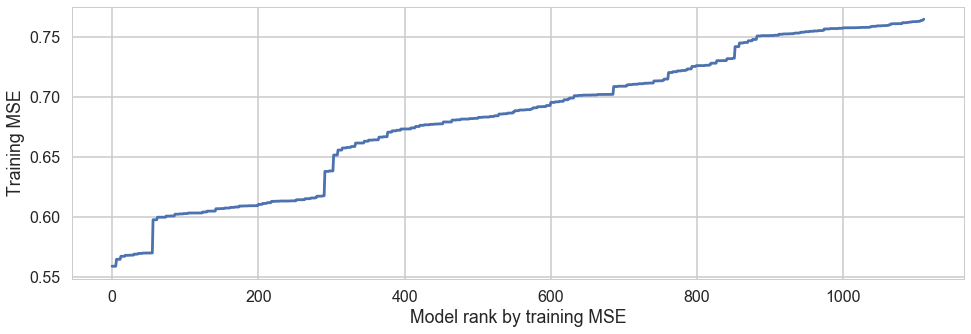

In [106]:
plt.figure(figsize = (16,5))
ax = plt.gca()
ax.plot(sorted(losses))
ax.set(xlabel = 'Model rank by training MSE', ylabel = 'Training MSE')

# Correlations
The correlation matrix below shows pairwise correlations between all non-bias features in the test set. We see that the data does not contain any strongly correlated features, but that of **density vs. alcohol**, **free sulfur dioxide vs. total sulfur dioxide**, and **residual sugar vs. density** are fairly signficant.

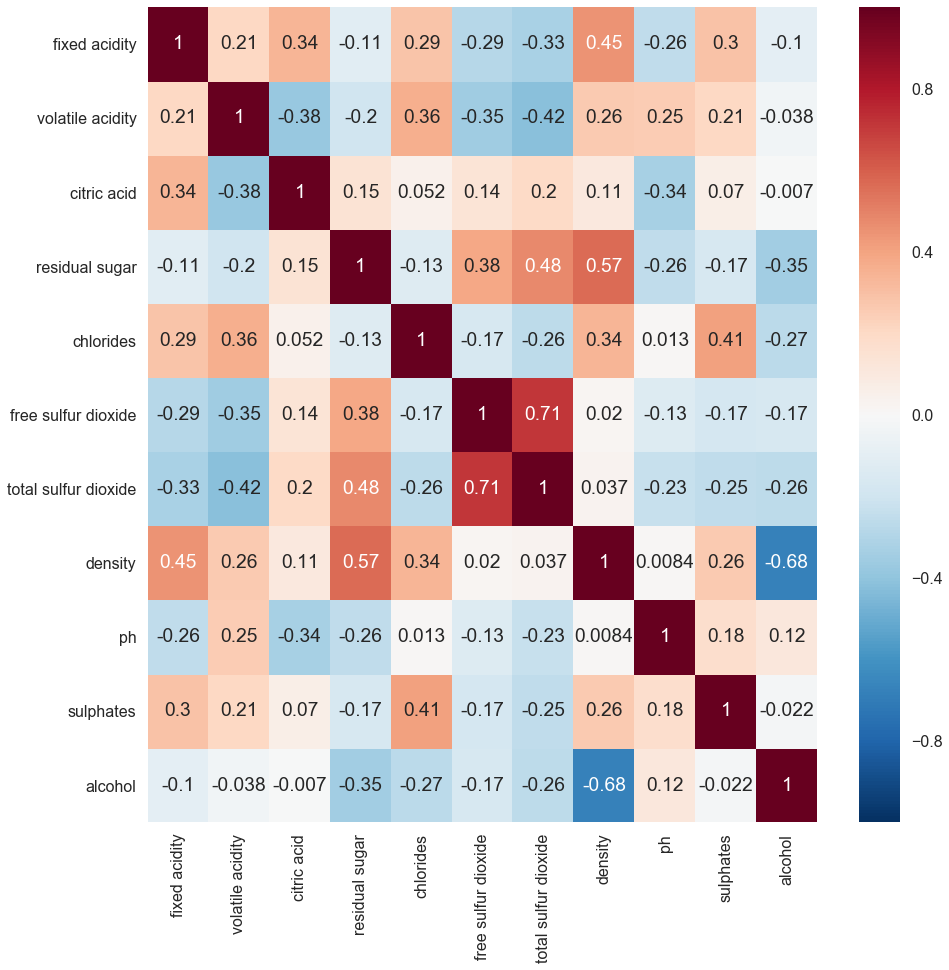

In [64]:
corr = X_test.iloc[1:,1:].corr()

plt.figure(figsize = (15,15))
sns.heatmap(corr, annot=True);

Plotting a correlation submatrix consisting of only the optimal features, we see that none are significantly correlated with each other.

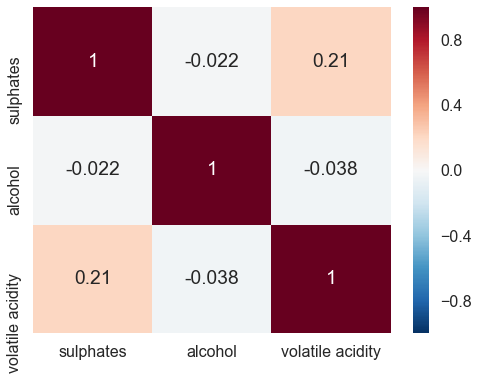

In [113]:
plt.figure(figsize = (8,6))
sns.heatmap(X_test[best_features_no_bias].corr(), annot=True)

Crucially, using the test data, we can for each feature of the optimal feature subset, find the two other features most correlated (or anti-correlated) with it. The results are displayed below. All features are unique, meaning each one contributes the maximum possible information to the model given the other two features. If the list features were not unique, this would indicate that two of the features in the optimal feature subset were sub-optimally correlated

In [93]:
best_features_no_bias = best_features[1:]
for best_feature in best_features_no_bias:
    feature_corr = corr[best_feature]
    feature_corr = pd.DataFrame([feature_corr, feature_corr.abs()], index = [best_feature, 'abs']).T
    feature_corr = feature_corr.sort_values(by = 'abs', ascending = False)
    print(feature_corr[best_feature][:3])
    print()

sulphates        1.000000
chlorides        0.406973
fixed acidity    0.296586
Name: sulphates, dtype: float64

alcohol           1.000000
density          -0.679581
residual sugar   -0.346407
Name: alcohol, dtype: float64

volatile acidity        1.000000
total sulfur dioxide   -0.421822
citric acid            -0.375747
Name: volatile acidity, dtype: float64

